In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
# Set the paths to your dataset directories
train_data_dir = r'C:/Users/Administrator/Desktop/LungcancerDataSet/Data/train'
val_data_dir = r'C:/Users/Administrator/Desktop/LungcancerDataSet/Data/valid'
test_data_dir = r'C:/Users/Administrator/Desktop/LungcancerDataSet/Data/test'

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load the datasets
train_dataset = image_dataset_from_directory(
    train_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = image_dataset_from_directory(
    val_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)


Found 1155 files belonging to 5 classes.
Found 127 files belonging to 5 classes.
Found 335 files belonging to 5 classes.


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))


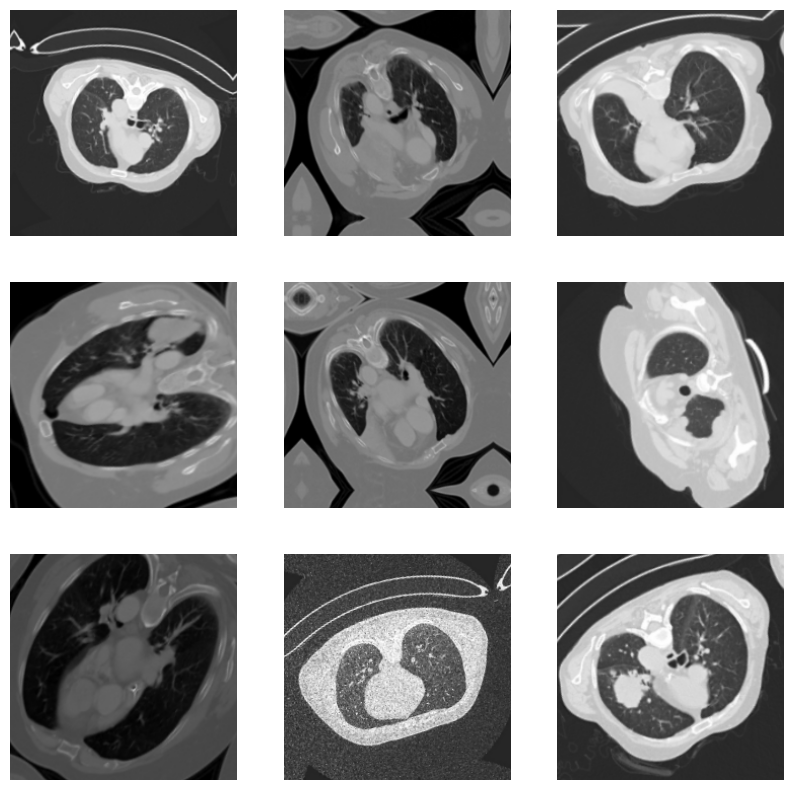

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization to avoid overfitting
    Dense(5, activation='softmax')  # Assuming 3 classes (malignant, benign, normal)
])


In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Start training the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
37/37 [==============================] - 224s 3s/step - loss: 82.8783 - accuracy: 0.4216 - val_loss: 3.1592 - val_accuracy: 0.2205
Epoch 2/20
37/37 [==============================] - 98s 2s/step - loss: 1.0703 - accuracy: 0.5039 - val_loss: 4.3306 - val_accuracy: 0.3386
Epoch 3/20
37/37 [==============================] - 104s 2s/step - loss: 1.0338 - accuracy: 0.5385 - val_loss: 3.6115 - val_accuracy: 0.2756
Epoch 4/20
37/37 [==============================] - 95s 2s/step - loss: 0.9796 - accuracy: 0.5671 - val_loss: 4.3330 - val_accuracy: 0.3543
Epoch 5/20
37/37 [==============================] - 74s 2s/step - loss: 0.9215 - accuracy: 0.6078 - val_loss: 3.4193 - val_accuracy: 0.3150
Epoch 6/20
37/37 [==============================] - 90s 2s/step - loss: 0.9257 - accuracy: 0.5870 - val_loss: 2.4157 - val_accuracy: 0.4488
Epoch 7/20
37/37 [==============================] - 149s 2s/step - loss: 0.8625 - accuracy: 0.6519 - val_loss: 2.2841 - val_accuracy: 0.3622
Epoch 8/20
37/37

In [14]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')


11/11 [==============================] - 15s 380ms/step - loss: 0.8293 - accuracy: 0.5761
Test accuracy: 0.5761194229125977


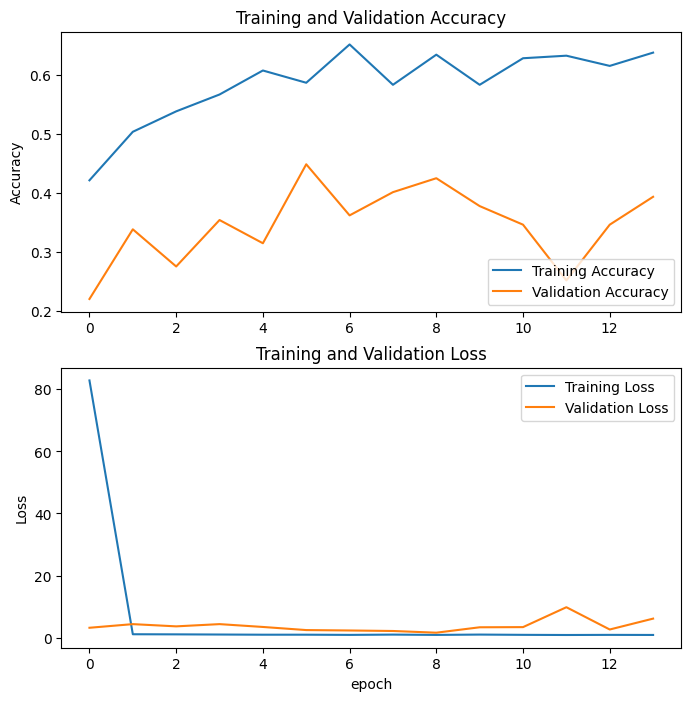

In [15]:
# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


11/11 [==============================] - 28s 372ms/step


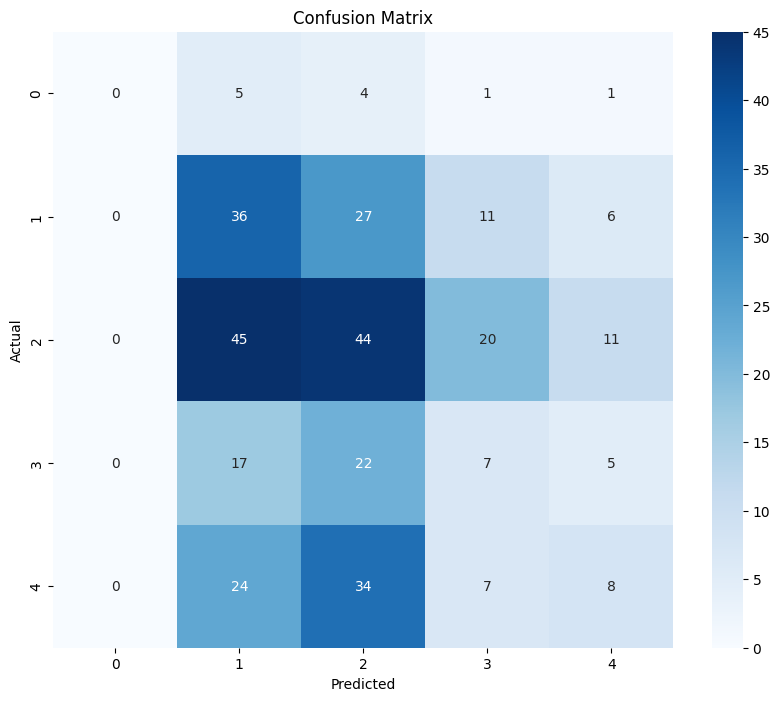

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the test dataset
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in test_dataset])

# Create confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from tensorflow.keras.preprocessing import image
img_path = r'C:\Users\Administrator\Desktop\LungcancerDataSet\Data\valid\normal\5.png'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])

# Print the results
print(f'Predicted class: {predicted_class}, Confidence: {confidence:.4f}')


1/1 [==============================] - 1s 1s/step
Predicted class: 3, Confidence: 0.3523


In [18]:
from tensorflow.keras.preprocessing import image
img_path = r'C:\Users\Administrator\Desktop\LungcancerDataSet\Data\valid\normal\Normal case (352).jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])

# Print the results
print(f'Predicted class: {predicted_class}, Confidence: {confidence:.4f}')


1/1 [==============================] - 0s 24ms/step
Predicted class: 3, Confidence: 0.3152
